# Bivariate Choropleth Maps

[Jeff Allen](http://jamaps.github.io)

April, 2023

Bivariate choropleth maps are pretty two-bular. They use **colour** to represent the values of **two** different data variables on the same map. Check out this map of neighbourhood material deprivation (a combined metric of lower income, education, employment rates, etc.) and quality of cycling infrastructure in Winnipeg.

<img src="images/winnipeg-bivariate-map.png" width="501">

Of course, we can always just map these two variables individually. However, overlaying them onto a single map can be incredibly useful for highlighting areas of correlation (or lack thereof) at different scales.

For example, in the bivariate map above, we can quickly identify areas with greater material deprivation but a lack of cycling infrastructure (in pink). These neighborhoods arguably should be at the top of the list for new investments in cycling infrastructure. The dark purple areas are those with high material deprivation but good cycling infrastructure, while the green areas are wealthier areas with good cycling infrastructure.

These types of maps can aid effective spatial storytelling and communication of findings, highlighting specific local areas of need, and be a useful exploratory analysis step before more sophisticated spatial modeling.

In this tutorial, we're going to cover how to create bivariate choropleth maps like these using [Python](https://www.python.org/), mostly using [geoPandas](https://geopandas.org/), with some final touch-ups and legend design in [Inkscape](https://inkscape.org/). The example data will be on urban health-related data in Canada (replicating the map above), but the methods and code can be applied to anywhere with two quantitative variables linked to the same set of geometries.

As a short side note on history, it is surprising that despite centuries of thematic maps showing multivariate data, bivariate choropleths are a recent creation. They gained popularity in the 1970s via maps created by the U.S. Bureau of the Census ([DOI](https://doi.org/10.1559/152304075784313250)). Here's one of their maps. I believe these were the first published bivariate maps, but if you are reading this and know of earlier bivariate maps, please let me know. I'd be super interested to see them.

<img src="images/us-census-income-education-1975-paper.png" width="501">

## Prerequisites

Prior knowledge of Python, including `pandas` and `geopandas`, as well as Inkscape or similar graphic design software, would be helpful for the following tutorial.

Click [here](https://github.com/schoolofcities/mapping-workshops-2023/raw/main/notebooks/bivariate-maps/bivariate-maps.zip) to download this article as a Jupyter Notebook alongside the datasets required. In the download, there is also a standalone Python script, if you want to run the steps all-at-once or integrate with anything else you have cooking.

You can also run the notebook [Binder](https://mybinder.org/v2/gh/schoolofcities/mapping-workshops-2023/HEAD?urlpath=lab%2Ftree%2Fnotebooks%2Fbivariate-maps%2Fbivariate-maps.ipynb)

If you are running the notebook and/or script locally (generally recommended), you will need to use the following libraries. You'll have to install them via `pip` or `conda` if you do not have them installed already.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import math
import pandas as pd
import geopandas as gpd
import mapclassify
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

## Loading Data

We're going to replicate the map of Winnipeg shown at the top of this page. I've pre-filtered the source datasets for Winnipeg, and they are included in the download link above. The datasets we'll be using are:
- [Census Dissemination Areas (DA) Polygons](https://www12.statcan.gc.ca/census-recensement/2021/geo/sip-pis/boundary-limites/index-eng.cfm)
- [Canadian Marginalization Index (CAN-Marg)](https://ontariohealthprofiles.ca/canmargCAN.php)
- [Canadian Bikeway Comfort and Safety Classification system (Can-BICS)](https://www.arcgis.com/home/item.html?id=c6d2917c4a7d4fb4a8e7a615369b68d5)

We're also going to add three additional layers solely for cartographic purposes (i.e. as reference layers on the final map)
- [Census Subdivision (CSD) Polygon](https://www12.statcan.gc.ca/census-recensement/2021/geo/sip-pis/boundary-limites/index-eng.cfm) - i.e. a boundary polygon for Winnipeg
- [Major Streets from OpenStreetMap](https://www.openstreetmap.org/#map=11/49.8787/-97.1514)
- [Rivers from OpenStreetMap](https://www.openstreetmap.org/#map=11/49.8787/-97.1514)

To get started, let's read the first three data layers and merge them into a single `geoDataFrame`, joining by the Dissemination Area unique id, `dauid`. We'll also load the three carotgraphic reference layers.

In [2]:
gdf = gpd.read_file("data/dissemination-area-winnipeg-2016.geojson")
dfm = pd.read_csv("data/can-marg-manitoba-2016.csv")
dfb = pd.read_csv("data/can-bics-winnipeg.csv")

gdf = gdf.merge(dfb, how='left', on='dauid').merge(dfm, how='left', on='dauid')

csd = gpd.read_file("data/csd-winnipeg-2016.geojson")
osm_streets = gpd.read_file("data/streets-osm-winnipeg.geojson")
osm_rivers = gpd.read_file("data/river-osm-winnipeg.geojson")

Let's pick two variables to map, one from each of the tabular datasets:
1) **Material resources** from CAN-Marg - an indicator of individual and community access to and attainment of basic material needs (including housing, income, education, employment). The higher the value, the fewer the resources (i.e. greater deprivation).
2) **Can-BICS continuous metric** - a weighted sum of the quality of bike infrastructure within a buffer of each DA. The higher the value, the better the infrastructure.

Here's a subset of what we want to map, the two variables noted above, plus the geometry data required to plot the data.

In [4]:
gdf[["dauid","material_resources_DA16","CBICS_cont","geometry"]].head(8)

,dauid,material_resources_DA16,CBICS_cont,geometry
0,46110001,-0.349423,0.000000,"MULTIPOLYGON (((-97.14934 49.99388, -97.14105 ..."
1,46110002,-0.747839,0.000000,"MULTIPOLYGON (((-97.09195 49.96864, -97.09705 ..."
2,46110003,-0.321103,0.000000,"MULTIPOLYGON (((-97.13213 49.95467, -97.13289 ..."
3,46110004,-0.958393,0.000000,"MULTIPOLYGON (((-97.13575 49.95428, -97.13695 ..."
4,46110005,0.420112,0.026394,"MULTIPOLYGON (((-97.13289 49.95334, -97.13418 ..."
5,46110006,-0.065753,0.026394,"MULTIPOLYGON (((-97.12985 49.94970, -97.13065 ..."
6,46110007,-0.277738,0.000000,"MULTIPOLYGON (((-97.12224 49.95150, -97.12321 ..."
7,46110008,-0.329884,0.020913,"MULTIPOLYGON (((-97.12579 49.94767, -97.12714 ..."


## Univariate Choropleth Maps

GeoPandas has a built-in `plot` function that makes it very easy to create univariate choropleth maps for any quantitative variable. In the code below, we use **quantiles** (equal number of DAs in each coloured group) to create choropleths using  `geopandas` and `matplotlib`. 

If you're interested in learning more about creating univariate choropleth maps in Python, including how to classify data, check out the Geographic Data Science textbook's [chapter](https://geographicdata.science/book/notebooks/05_choropleth.html) on the topic. You can also refer to the `geopandas.GeoDataFrame.plot` [documentation](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html) for more information.

Creating similar maps in QGIS is also straightforward. Simply load the data, right-click on the layer, go to `properties`, then `symbology`, and then select `Graduated`. From here, you'll have access to a wide range of options for colours and classification schemes to create informative univariate choropleth maps.

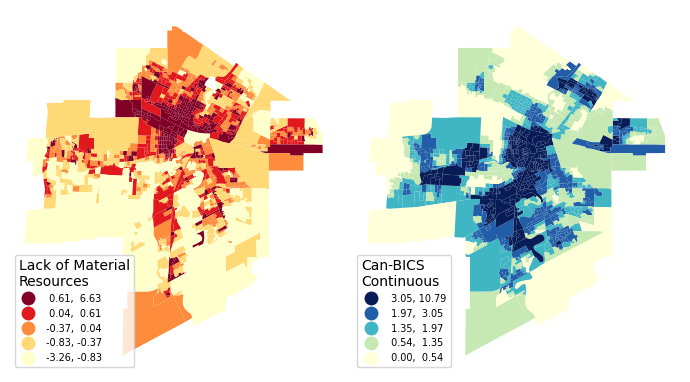

In [7]:
fig, ax = plt.subplots(ncols=2, figsize=(7,6))

gdf.plot(
    column = "material_resources_DA16", 
    cmap = 'YlOrRd', 
    k = 5,
    scheme = "Quantiles", 
    legend = True,
    ax=ax[0],
    legend_kwds = {
        "loc": "lower left",
        "fontsize": 7,
        "title": "Lack of Material\nResources",
        "alignment": "left",
        "reverse": True
    }
).set_axis_off();

gdf.plot(
    column = "CBICS_cont", 
    cmap = 'YlGnBu', 
    scheme = "Quantiles", 
    legend = True,
    ax=ax[1],
    legend_kwds = {
        "loc": "lower left",
        "fontsize": 7,
        "title": "Can-BICS\nContinuous",
        "alignment": "left",
        "reverse": True
    }
).set_axis_off();

plt.tight_layout()

## Bivariate Classifications

The first step towards creating a bivariate map is to classify our data.

I'll be focusing 3x3 classifications using quantiles, but the same principles can be applied to any classification type.

A bivariate classification has two dimensions, let's call those `X` and `Y`. The legend can be visualized as a 2-dimensional chart. For this example, I'm classifying each dimension into three categories, terming them 0 (low), 1, and 2 (high). We then **concatenate** these two categories together to create a joint classification. For example, a high value in the X dimension and a low value in the Y dimension would be classified as `2-0`. 

We can then colour based on this joint classification.

<img src="images/eg-legend-classify.svg" width="310">

But how do we do this in Python and geopandas? Behind the scenes of the univariate choropleth maps in the previous section is a Python library called [mapclassify](https://github.com/pysal/mapclassify).

Here's an example classifying the Can-BICS variable into `k = 3` quantiles (changing this to k = 5 gives us the same classification in the map above)

In [8]:
mapclassify.Quantiles(gdf["CBICS_cont"], k = 3)

Quantiles

   Interval      Count
----------------------
[ 0.00,  1.15] |   373
( 1.15,  2.25] |   372
( 2.25, 10.79] |   373

We can use the same function to generate bivariate classifications. Below we create 3x3 square classification using quantiles. A `k = 3` for each variable `X` (Can-BICS cycling infrastructure quality) and `Y` (Can-MARG lack of material resources), and then combine the two together.

In [20]:
gdf['x_group'] = gdf[['CBICS_cont']].apply(mapclassify.Quantiles.make(rolling=True, k = 3))
gdf['y_group'] = gdf[['material_resources_DA16']].apply(mapclassify.Quantiles.make(rolling=True, k = 3))
gdf['xy_group'] = gdf['x_group'].astype(str) + "-" + gdf['y_group'].astype(str)

Here's a random sample of the result that we can use to spot check a few results

In [22]:
gdf[["dauid","material_resources_DA16","CBICS_cont",'x_group',"y_group","xy_group"]].sample(5)

,dauid,material_resources_DA16,CBICS_cont,x_group,y_group,xy_group
509,46110546,-0.570719,3.677031,2,0,2-0
107,46110108,-0.258522,0.226581,0,1,0-1
684,46110741,-0.149318,2.971448,2,1,2-1
978,46111074,-0.949989,1.141521,0,0,0-0
785,46110855,-0.488178,1.340795,1,1,1-1


Now we are ready to make a bivariate map!

At this stage, we can also save the classified data to then view it in QGIS or use for web-mapping: `gdf.to_file("data/winnipeg-bivariate.geojson", driver='GeoJSON')`

## Bivariate Colours

Now that we've classified our data, we can assign colours and make a map! 

Here are a few examples for colouring that we can choose from:

<img src="images/eg-legends.svg" width="620">

Let's try to make a simple map using `gpd.plot()` based on our classified data and the first of these colour schemes. 

The data we have are categorical. To plot categorical data with custom colours, we first have to provide a dictionary to *map* each category to each colour.

In [23]:
color_mapping = {
    "0-2": "#f73593", 
    "0-1": "#f78fb6",
    "0-0": "#f7fcf5", 
    "1-2": "#a53593",
    "1-1": "#a58fb6", 
    "1-0": "#a5e8cd", 
    "2-2": "#403593",
    "2-1": "#408fa7",
    "2-0": "#40dba7" 
}

We can then feed this into our plot. We're also going to add the reference layers to make the map a bit more intuitive; the Winnipeg boundary, streets, and rivers.

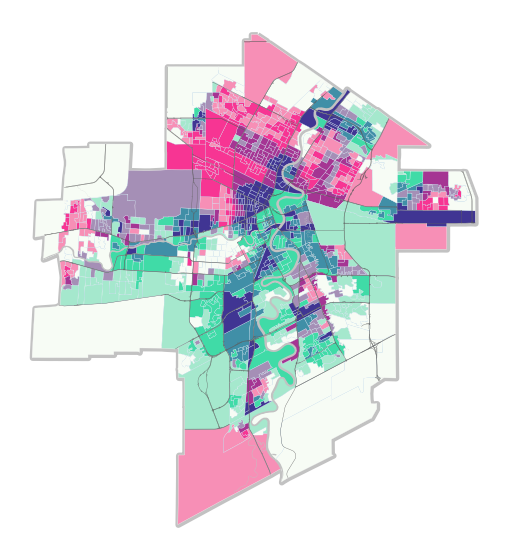

In [27]:
fig, ax = plt.subplots(figsize=(7,7))

# Winnipeg border
csd.plot(
    edgecolor = "#c2c2c2",
    linewidth = 4.2,
    ax = ax
);

# bivariate data
gdf.plot(
    column = "xy_group",
    categorical = True,
    edgecolor = "white",
    linewidth = 0.2,
    ax = ax,
    color=gdf["xy_group"].map(color_mapping),
).set_axis_off();

# Winnipeg rivers
osm_rivers.plot(
    color = "#c2c2c2",
    linewidth = 0,
    ax = ax
);

# Winnipeg streets
osm_streets.plot(
    color = "#5e5e5e",
    linewidth = 0.25,
    ax = ax
);

# custom legend
legend_elements = []
for key, value in color_mapping.items():
    legend_elements.append(Patch(facecolor=value, edgecolor='gray', label=""))
ax.legend(
    handles=legend_elements, 
    loc='lower right', 
    fontsize= 12, 
    ncol=3, 
    handletextpad=0.1, 
    labelspacing = 0.1, 
    columnspacing = 0.1
)
ax.text(0.55, 0.1, 'Material\nDeprivation', transform=ax.transAxes, fontsize=10, verticalalignment='top')
ax.text(0.75, 0.01, 'Quality of Cycling\nInfrastructure', transform=ax.transAxes, fontsize=10, verticalalignment='top')

Looks great! One wrinkle, however, is that we had to create a custom legend because simply setting`legend = True` didn't work initially. It appears that there is a [known issue](https://github.com/geopandas/geopandas/issues/1269) with plotting categorical data with custom colours. We can try to continue to tinker with this map using `matplotlib`, but personally, I prefer to design more nuanced layout items, such as legends, using graphic design software like Inkscape, particularly if the goal is to create visually appealing "static" maps for an article or report.

In [28]:
fig.savefig('images/winnipeg-bivariate-map-python-export.png')

## Layout Design in Inkscape

The line of code above exports the figure as an `.svg` (Scalable Vector Graphic). We can open it up in Inkscape (or similar graphic design software) and add layout items such as a title, legend, scale bar, north arrow, and other information.

The page size is set to 7x7 inches based on the `plt.subplots(figsize=(7,7))` included at the top of the code used to render the map.

Generally, my workflow is to create at least three layers in the following order:
- layout (title, legend, scale bar, north arrow, and other info)
- map (in this case, the original exported .svg)
- background (often just a single rectangle with a solid fill colour)

These can be expanded into more layers (or sub-layers) if desired.

From a cartographic design side, it's important to aim for *balance*. This is a bit of a subjective notion pertaining to the visual weight of the elements of an image. For example, in the map below, I tried to balance the layout by putting one item in each corner. I purposely used the bottom-left corner for the legend since it takes up the most space and fits nicely within the square-ish cutout of Winnipeg's border.

I also used a grid to align some of the items such as the map frame, title, north arrow, and scale bar. Overall, creating these layout items didn't take too long, around 20 minutes or so.

Here's a screenshot of Inkscape showing all the items in the `layout` layer that I created.

<img src="images/inkscape-screenshot.png" width="700">

And here's the final map! We can export this to any resolution that we want. This is 300dpi for 7"x7" (2100x2100 px), a nice size for fitting into a report.

<img src="images/winnipeg-bivariate-map.png" width="699">

## Final Thoughts

The classification method (e.g., quantiles, equal breaks, etc.), the number of classes, and of course, the colours can easily be tinkered with.

A noted drawback with bivariate maps is that they are often not initially intuitive and sometimes require a good amount of looking back-and-forth with the legend, especially compared to univariate choropleth maps. Even with a 3x3 legend like the map above, it can take a bit of time to read the map and understand and parse out specific values (especially for the middle values). If you're more interested in understanding each variable on its own, rather than a direct comparison, it's probably best to stick with two side-by-side univariate choropleth maps. If you want to allow for comparison but keep things easier to read, a 2x2 legend might be better, but remember that different aggregation can lead to varying results!

## Additional Resources

- [Wikipedia page on multivariate maps](https://en.wikipedia.org/wiki/Multivariate_map)
- [Color Statistical Mapping by the U.S. Bureau of the Census](https://doi.org/10.1559/152304075784313250) | (what I think might be the first published bivariate maps)
- [Bivariate maps in QGIS](https://www.joshuastevens.net/cartography/make-a-bivariate-choropleth-map/) | by Joshua Stevens
- [Bivariate maps in R](https://timogrossenbacher.ch/2019/04/bivariate-maps-with-ggplot2-and-sf/) | by Timo Grossenbacher